<a href="https://colab.research.google.com/github/Bertaalcolea/Collagen_studies/blob/main/dECM5(con90/10).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mc
import colorsys


In [5]:
def load_bmg_kinetic_v2(filepath, sheet_name=0):
    """
    Lee el Excel del lector BMG y devuelve un DataFrame 'largo' con:
    time_min, row, col, sample_id, od
    """
    df = pd.read_excel(filepath, sheet_name=sheet_name)

    # ---- Layout: qué SPL hay en cada pocillo ----
    layout_idx = df.index[df.iloc[:, 0] == 'Layout'][0]

    # Fila con números de columna (1,2,3,4,5,6...)
    colnums_row = df.iloc[layout_idx + 2, :]

    well_cols_pos = [
        pos for pos, val in enumerate(colnums_row)
        if isinstance(val, (int, float)) and not pd.isna(val)
    ]

    layout_rows_idx = range(layout_idx + 3, layout_idx + 11)  # filas A–H
    well_to_sample = {}

    for i in layout_rows_idx:
        row_letter = df.iloc[i, 1]
        if not isinstance(row_letter, str):
            continue
        for pos in well_cols_pos:
            col_num = int(colnums_row.iloc[pos])
            sample_id = df.iloc[i, pos]
            if isinstance(sample_id, str):
                well_to_sample[(row_letter, col_num)] = sample_id

    # ---- Bloques de tiempo ("350 - Time ...") ----
    time_rows = df.index[
        df.iloc[:, 0].astype(str).str.contains('350 - Time', na=False)
    ].tolist()

    records = []
    nrows = df.shape[0]

    for t_idx in time_rows:
        # Tiempo en minutos
        time_str = str(df.iloc[t_idx, 0])
        m = re.search(r'\((\d+):(\d+):(\d+)\)', time_str)
        if m:
            h, mn, s = map(int, m.groups())
            time_min = (h * 3600 + mn * 60 + s) / 60.0
        else:
            time_min = np.nan

        # Buscar fila de cabecera con números de columna
        header_idx = None
        header_numeric_pos = None
        for cand in range(t_idx + 1, min(t_idx + 20, nrows)):
            row = df.iloc[cand, :]
            numeric_pos = [
                pos for pos, val in enumerate(row)
                if isinstance(val, (int, float)) and not pd.isna(val)
            ]
            if len(numeric_pos) >= 3:
                header_idx = cand
                header_numeric_pos = numeric_pos
                break

        if header_idx is None:
            continue

        # 8 filas siguientes = A–H con valores de OD
        data = df.iloc[header_idx + 1:header_idx + 1 + 8, :]

        for i in range(data.shape[0]):
            row_letter = data.iloc[i, 1]
            if not isinstance(row_letter, str):
                continue
            for pos in header_numeric_pos:
                val_header = df.iloc[header_idx, pos]
                if pd.isna(val_header):
                    continue
                col_num = int(val_header)

                val_od = data.iloc[i, pos]
                if pd.isna(val_od):
                    continue

                sample_id = well_to_sample.get((row_letter, col_num))
                if sample_id is None:
                    continue

                records.append({
                    'time_min': time_min,
                    'row': row_letter,
                    'col': col_num,
                    'sample_id': sample_id,
                    'od': float(val_od),
                })

    return pd.DataFrame.from_records(records)


In [6]:
filename = "dECM5PEP_NOPEP.xlsx"   # cambia si el nombre es otro
long_df = load_bmg_kinetic_v2(filename)

print(long_df.head())
print(long_df.shape)


   time_min row  col sample_id     od
0       0.2   A    1      SPL1  0.189
1       0.2   A    2      SPL5  0.174
2       0.2   A    3      SPL9  0.151
3       0.2   A    4     SPL13  1.318
4       0.2   A    5     SPL17  0.510
(4719, 5)


In [7]:
def build_meta_from_rowcol(df):
    rows = df[['row', 'col', 'sample_id']].drop_duplicates()
    records = []

    for _, r in rows.iterrows():
        row_letter = r['row']
        col = int(r['col'])

        meta = {
            'row': row_letter,
            'col': col,
            'sample_id': r['sample_id'],
            'group': row_letter,
            'type': None,
            'paa': None,
            'hours': None,
            'pepsin': None,
        }

        # ---- dECM A–D ----
        if row_letter in ['A', 'B', 'C', 'D']:
            meta['type'] = 'dECM'
            if col in [1, 2, 3]:
                meta['pepsin'] = True   # + pepsina
            elif col in [4, 5, 6]:
                meta['pepsin'] = False  # - pepsina

            if row_letter == 'A':
                meta['paa'] = 'PAA'
                meta['hours'] = 24
            elif row_letter == 'B':
                meta['paa'] = 'no-PAA'
                meta['hours'] = 24
            elif row_letter == 'C':
                meta['paa'] = 'PAA'
                meta['hours'] = 48
            elif row_letter == 'D':
                meta['paa'] = 'no-PAA'
                meta['hours'] = 48

        # ---- Rat E ----
        elif row_letter == 'E':
            if col in [1, 2, 3]:
                meta['type'] = 'Rat 1.5 mg/ml'
            elif col in [4, 5, 6]:
                meta['type'] = 'Rat 90/10'

        # ---- Bov F ----
        elif row_letter == 'F':
            if col in [1, 2, 3]:
                meta['type'] = 'Bov 1.5 mg/ml'
            elif col in [4, 5, 6]:
                meta['type'] = 'Bov 90/10'

        # ---- Control G ----
        elif row_letter == 'G':
            meta['type'] = 'Control'

        records.append(meta)

    return pd.DataFrame(records)

meta_df = build_meta_from_rowcol(long_df)
long_meta = long_df.merge(meta_df, on=['row', 'col', 'sample_id'], how='left')

long_meta.head()


,time_min,row,col,sample_id,od,group,type,paa,hours,pepsin
0,0.2,A,1,SPL1,0.189,A,dECM,PAA,24.0,True
1,0.2,A,2,SPL5,0.174,A,dECM,PAA,24.0,True
2,0.2,A,3,SPL9,0.151,A,dECM,PAA,24.0,True
3,0.2,A,4,SPL13,1.318,A,dECM,PAA,24.0,False
4,0.2,A,5,SPL17,0.510,A,dECM,PAA,24.0,False


In [8]:
def pastel(color, factor=0.45):
    c = mc.to_rgb(color)
    h, l, s = colorsys.rgb_to_hls(*c)
    l = min(1, l + factor * (1 - l))
    s = max(0, s * (1 - factor/2))
    r, g, b = colorsys.hls_to_rgb(h, l, s)
    return (r, g, b)

# dECM base (pH ajustado)
base_colors = {
    'no-PAA 24h': '#fdae61',  # naranja
    'PAA 24h'   : '#984ea3',  # morado
    'no-PAA 48h': '#00bfc4',  # cian
    'PAA 48h'   : '#d73027',  # rojo
}

color_map_dECM = {}
for cond, col in base_colors.items():
    color_map_dECM[(cond, '+ pepsin')] = col
    color_map_dECM[(cond, '- pepsin')] = pastel(col, 0.45)

core_order = ['no-PAA 24h', 'PAA 24h', 'no-PAA 48h', 'PAA 48h']

# Controles: fuerte + pastel
color_map_ctrl = {
    'Rat 1.5 mg/ml': '#4575b4',
    'Rat 90/10'    : pastel('#4575b4', 0.45),
    'Bov 1.5 mg/ml': '#1a9850',
    'Bov 90/10'    : pastel('#1a9850', 0.45),
    'Control'      : '#000000',
}


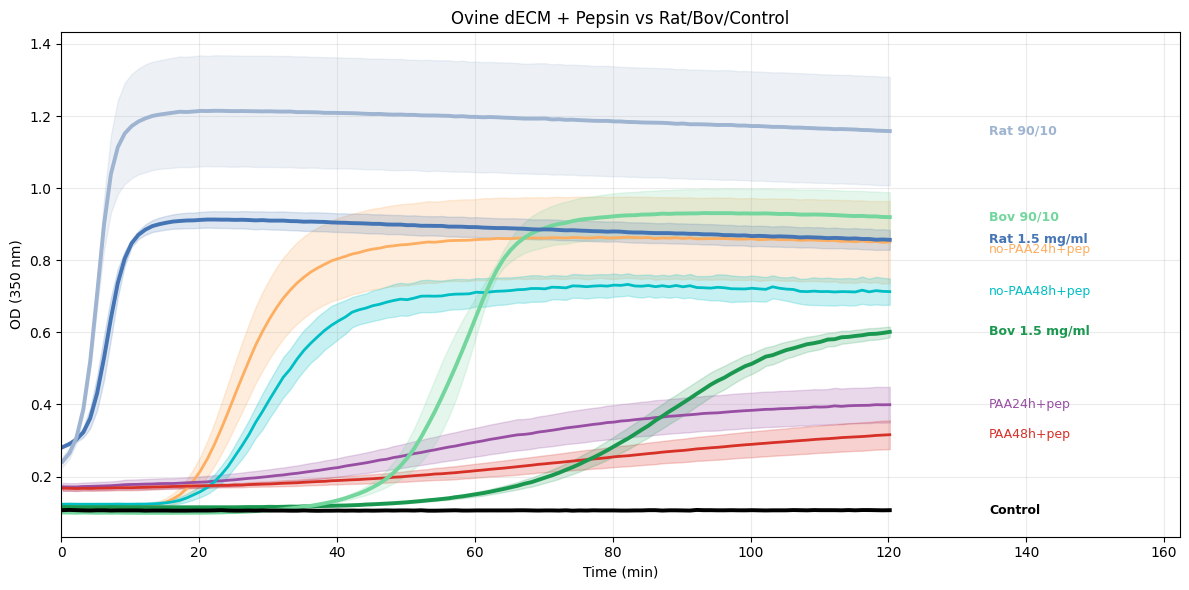

In [9]:
# --- resumen dECM +pepsin ---
dec_pep = long_meta[(long_meta['type']=='dECM') & (long_meta['pepsin']==True)].copy()
dec_pep['hours'] = dec_pep['hours'].astype(int)
dec_pep['cond_core'] = dec_pep['paa'] + ' ' + dec_pep['hours'].astype(str) + 'h'

summary_pep = (
    dec_pep
    .groupby(['time_min','cond_core'])['od']
    .agg(['mean','std','count'])
    .reset_index()
)

# --- resumen controles (5 tipos) ---
rbc = long_meta[long_meta['type'].isin([
    'Rat 1.5 mg/ml','Rat 90/10',
    'Bov 1.5 mg/ml','Bov 90/10',
    'Control'
])].copy()

summary_rbc = (
    rbc
    .groupby(['time_min','type'])['od']
    .agg(['mean','std','count'])
    .reset_index()
)

plt.figure(figsize=(12,6))

# dECM +pepsin
for cond in core_order:
    df = summary_pep[summary_pep['cond_core']==cond].sort_values('time_min')
    if df.empty:
        continue

    x = df['time_min'].values
    y = df['mean'].values
    se = df['std'].fillna(0).values / np.sqrt(df['count'].values)
    color = color_map_dECM[(cond, '+ pepsin')]

    plt.fill_between(x, y-se, y+se, color=color, alpha=0.22)
    plt.plot(x, y, color=color, linewidth=2)

    label = cond.replace(' ', '') + '+pep'

    # --- ajuste de posición de la etiqueta ---
    # por defecto, sin desplazamiento vertical
    y_offset = 0.0
    # mover la naranja (no-PAA 24h +pep) un poco más abajo
    if cond == 'no-PAA 24h':
        y_offset = -0.02

    plt.text(
        x[-1] * 1.12,      # más a la derecha
        y[-1] + y_offset,  # con offset si toca
        label,
        color=color,
        fontsize=9,
        va='center'
    )

# Controles
for cond, dfc in summary_rbc.groupby('type'):
    dfc = dfc.sort_values('time_min')
    x = dfc['time_min'].values
    y = dfc['mean'].values
    se = dfc['std'].fillna(0).values / np.sqrt(dfc['count'].values)
    color = color_map_ctrl[cond]

    plt.fill_between(x, y-se, y+se, color=color, alpha=0.18)
    plt.plot(x, y, color=color, linewidth=2.8)

    plt.text(
        x[-1] * 1.12,
        y[-1],
        cond,
        color=color,
        fontsize=9,
        va='center',
        fontweight='bold'
    )

plt.xlabel("Time (min)")
plt.ylabel("OD (350 nm)")
plt.title("Ovine dECM + Pepsin vs Rat/Bov/Control")
plt.grid(alpha=0.25)

xmax = max(summary_pep['time_min'].max(), summary_rbc['time_min'].max())
plt.xlim(0, xmax * 1.35)   # aún más margen a la derecha

# sin legend()
plt.tight_layout()
plt.show()


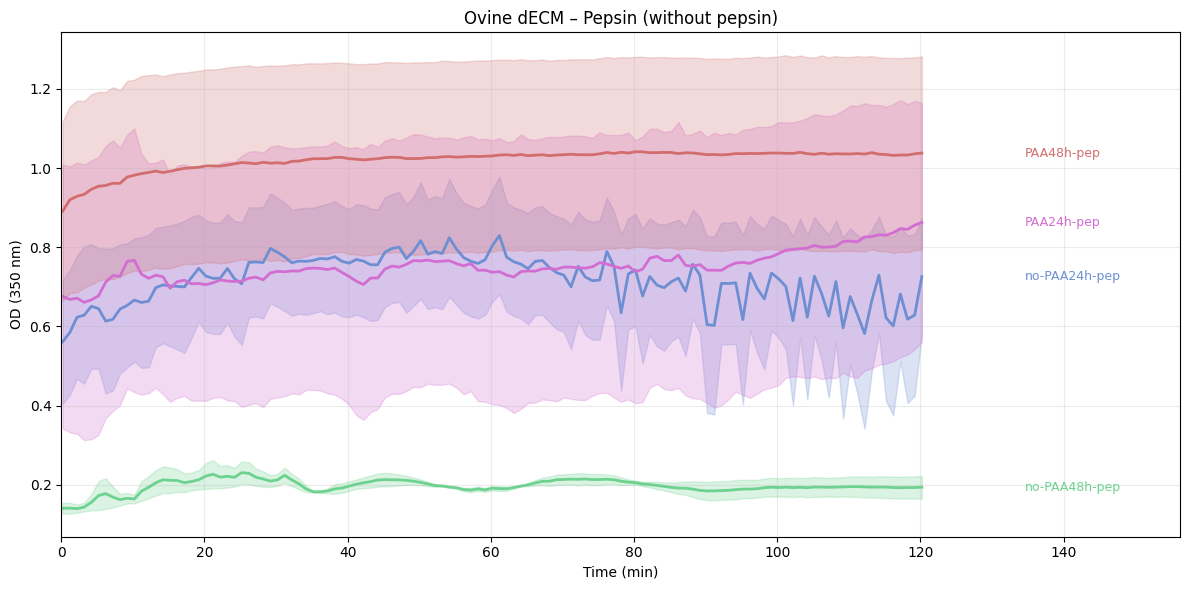

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mc
import colorsys

# =========================
# 1) Colores fuertes + pasteles moderados
# =========================

def pastel(color, factor=0.25):
    """Devuelve el mismo color en pastel moderado (más visible)."""
    c = mc.to_rgb(color)
    h, l, s = colorsys.rgb_to_hls(*c)
    l = min(1, l + factor*(1-l))
    s = max(0, s*(1-factor/2))
    r, g, b = colorsys.hls_to_rgb(h, l, s)
    return (r, g, b)

# Colores base (pH ajustado, intensos)
base_colors = {
    'no-PAA 24h':  '#3366CC',  # AZUL ROYAL fuerte
    'PAA 24h'   :  '#CC33CC',  # MAGENTA intenso
    'no-PAA 48h':  '#33CC66',  # VERDE LIMA profundo
    'PAA 48h'   :  '#CC3333',  # ROJO CARMESÍ fuerte
}

# Mapa dECM para ± pepsin (lo puedes reutilizar en otros plots)
color_map_dECM = {}
for cond, col in base_colors.items():
    color_map_dECM[(cond, '+ pepsin')] = col
    color_map_dECM[(cond, '- pepsin')] = pastel(col, 0.25)

core_order = ['no-PAA 24h', 'PAA 24h', 'no-PAA 48h', 'PAA 48h']

# =========================
# 2) Resumen dECM SIN pepsina
# =========================

dec_nopep = long_meta[(long_meta['type']=='dECM') & (long_meta['pepsin']==False)].copy()
dec_nopep['hours'] = dec_nopep['hours'].astype(int)
dec_nopep['cond_core'] = dec_nopep['paa'] + ' ' + dec_nopep['hours'].astype(str) + 'h'

summary_nopep = (
    dec_nopep
    .groupby(['time_min','cond_core'])['od']
    .agg(['mean','std','count'])
    .reset_index()
)

# =========================
# 3) Figura dECM – Pepsin (sin pepsina)
# =========================

plt.figure(figsize=(12,6))

for cond in core_order:
    df = summary_nopep[summary_nopep['cond_core']==cond].sort_values('time_min')
    if df.empty:
        continue

    x = df['time_min'].values
    y = df['mean'].values
    se = df['std'].fillna(0).values / np.sqrt(df['count'].values)
    color = color_map_dECM[(cond, '- pepsin')]

    # banda ±SE
    plt.fill_between(x, y-se, y+se, color=color, alpha=0.25)
    # línea
    plt.plot(x, y, color=color, linewidth=2)

    # etiqueta al final de cada curva
    label = cond.replace(' ', '') + '-pep'
    plt.text(
        x[-1]*1.12,
        y[-1],
        label,
        color=color,
        fontsize=9,
        va='center'
    )

plt.xlabel("Time (min)")
plt.ylabel("OD (350 nm)")
plt.title("Ovine dECM – Pepsin (without pepsin)")

plt.grid(alpha=0.25)
plt.xlim(0, summary_nopep['time_min'].max() * 1.3)  # margen derecho extra

# sin legend(), todas las etiquetas están en las curvas
plt.tight_layout()
plt.show()
